# Test Benchmarking

This file is to test some benchmarking of the $\mathcal{O}(n \log n)$ implementation of the t-SNE algorithm.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Customize matplotlib
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

Read the data.

In [3]:
start = 200
stop = 4000
interval = 200

input_size = np.arange(start, stop+1, interval)

it = []
it_ec = []
it_buildFromPoints = []
it_ins = []
it_sub = []

with open("../implementations/tsne_nlogn/benchmarking/20170506_141917@-O3 -march=native@iters.txt", 'r') as f:
    for line in f:
        tokens = line.strip().split(' ')
        if tokens[0] == 'it':
            it.append(int(tokens[1]))
        elif tokens[0] =='it_ec':
            it_ec.append(int(tokens[1]))
        elif tokens[0] =='it_buildFromPoints':
            it_buildFromPoints.append(int(tokens[1]))
        elif tokens[0] =='it_ins':
            it_ins.append(int(tokens[1]))
        elif tokens[0] =='it_sub':
            it_sub.append(int(tokens[1]))

it = np.array(it).astype("float")
it_ec = np.array(it_ec).astype("float")
it_buildFromPoints = np.array(it_buildFromPoints).astype("float")
it_ins = np.array(it_ins).astype("float")
it_sub = np.array(it_sub).astype("float")

cycles = np.loadtxt("../implementations/tsne_nlogn/benchmarking/20170506_141917@-O3 -march=native@cycles.txt")
assert np.all(cycles[:,:-1].sum(axis=1) == cycles[:,-1])

Now compute the flops operations.

In [4]:
N = input_size.astype("float")
D = 28 * 28
d = 2
T = 1000   # Number of iterations
K = 3 * 50 #conserider neighbors

count_measure=("add", "mult", "div", "exp", "log")

Define some auxiliar functions.

In [5]:
def sum_operations_by_measure(flops):
    flops_count = dict()
    #for measure in count_measure:
    #    flops_count[measure] = 
    for k, v in flops.items(): 
        for op, cycles in v.items():
            if op not in flops_count:
                flops_count[op] = cycles.copy()
            else:
                flops_count[op] += cycles.copy()
                
    return flops_count

def sum_operations(flops):
    flops_count = None
    for k, v in flops.items():
        if flops_count is None:
            flops_count = v.copy()
        else:
            flops_count += v.copy()
    return flops_count

def sum_operations_by_function(flops, function_list=("normalize", "compute_pairwise_affinity_perplexity",
                                                    "symmetrize_affinities", "early_exageration",
                                                    "compute_low_dimensional_affinities", 
                                                    "gradient_computation", "gradient_update", 
                                                    "normalize_2"), size=N.shape[0]):
    flops_count = np.zeros((size, len(function_list)), dtype="float")
    
    for i, func in enumerate(function_list):
        flops_count[:,i] += sum_operations(flops[func])
    return flops_count

In [6]:
flops = {
    "normalize": {
        "add": 2 * N * D,
        "div": D + N * D
    },
    "compute_pairwise_affinity_perplexity": {
        "add": it * (2*K + 2) + it_ec * 2 * D,
        "mult": it * (3*K) + it_ec * D + it_buildFromPoints,
        "div": it * 2 + N * K + it_buildFromPoints,
        "exp": it * K,
        "log": it * 2,
        "sqrt": it_ec
    },
    "symmetrize_affinities": {
        "add": N*K*3,
        "div": N*K*2
    },
    "early_exageration": {
        "mult": 2 * N*K
    },
    "compute_low_dimensional_affinities": {
        "compute_squared_euclidean_distance": {
            "add": T * d * N*(N-1)/2 * 2,
            "mult": T * d * N*(N-1)/2
        },
        "compute": {
            "add": T * N * (N-1) * 2,
            "div": T * N * (N-1)
        }
    },
    "gradient_computation": {
        "add": T*N*(d + 1) + it_ins * d + it_sub * d + T*(N*K*3*d+N) + T*N*d,
        "mult": it_ins * 2 * d + it_sub * 2 * d + T*(N*K*2*d),
        "div": T*d * (1 + 3) + T*N*K +  T*N*d
    },
    "gradient_update": {
        "add": T * (N*d + N * d * 2),
        "mult": T * N * d * 3
    },
    "normalize_2": {
        "add": T * 2 * N * d,
        "div": T * (d + N * d)
    }
}

# Reduce the previous dictionary to the main functions which cycles have been counted.
flops_by_function_measure = dict(flops)
flops_by_function_measure["compute_low_dimensional_affinities"] = \
    sum_operations_by_measure(flops["compute_low_dimensional_affinities"])
flops_by_function = sum_operations_by_function(flops_by_function_measure)

Compute the total number of flops.

In [7]:
total_flops = sum_operations_by_measure(flops_by_function_measure)
total_flops = sum_operations(total_flops)
print(total_flops)

[  6.99279331e+08   2.07766580e+09   4.11591539e+09   6.83198728e+09
   1.02131181e+10   1.42710345e+10   1.89919030e+10   2.43873921e+10
   3.04485758e+10   3.71646769e+10   4.45715740e+10   5.26113849e+10
   6.13606961e+10   7.06542634e+10   8.08046119e+10   9.15325612e+10
   1.02905475e+11   1.15005808e+11   1.27574865e+11   1.41114652e+11]


In [8]:
performance_total = total_flops / cycles[:,-1]
print(performance_total)

[ 0.1425657   0.17224786  0.19323205  0.19994038  0.21304007  0.20378296
  0.21331564  0.18875276  0.21630004  0.20755811  0.22626337  0.19969994
  0.22814835  0.20202407  0.21978516  0.2031339   0.21912366  0.20156166
  0.1999325   0.20577445]


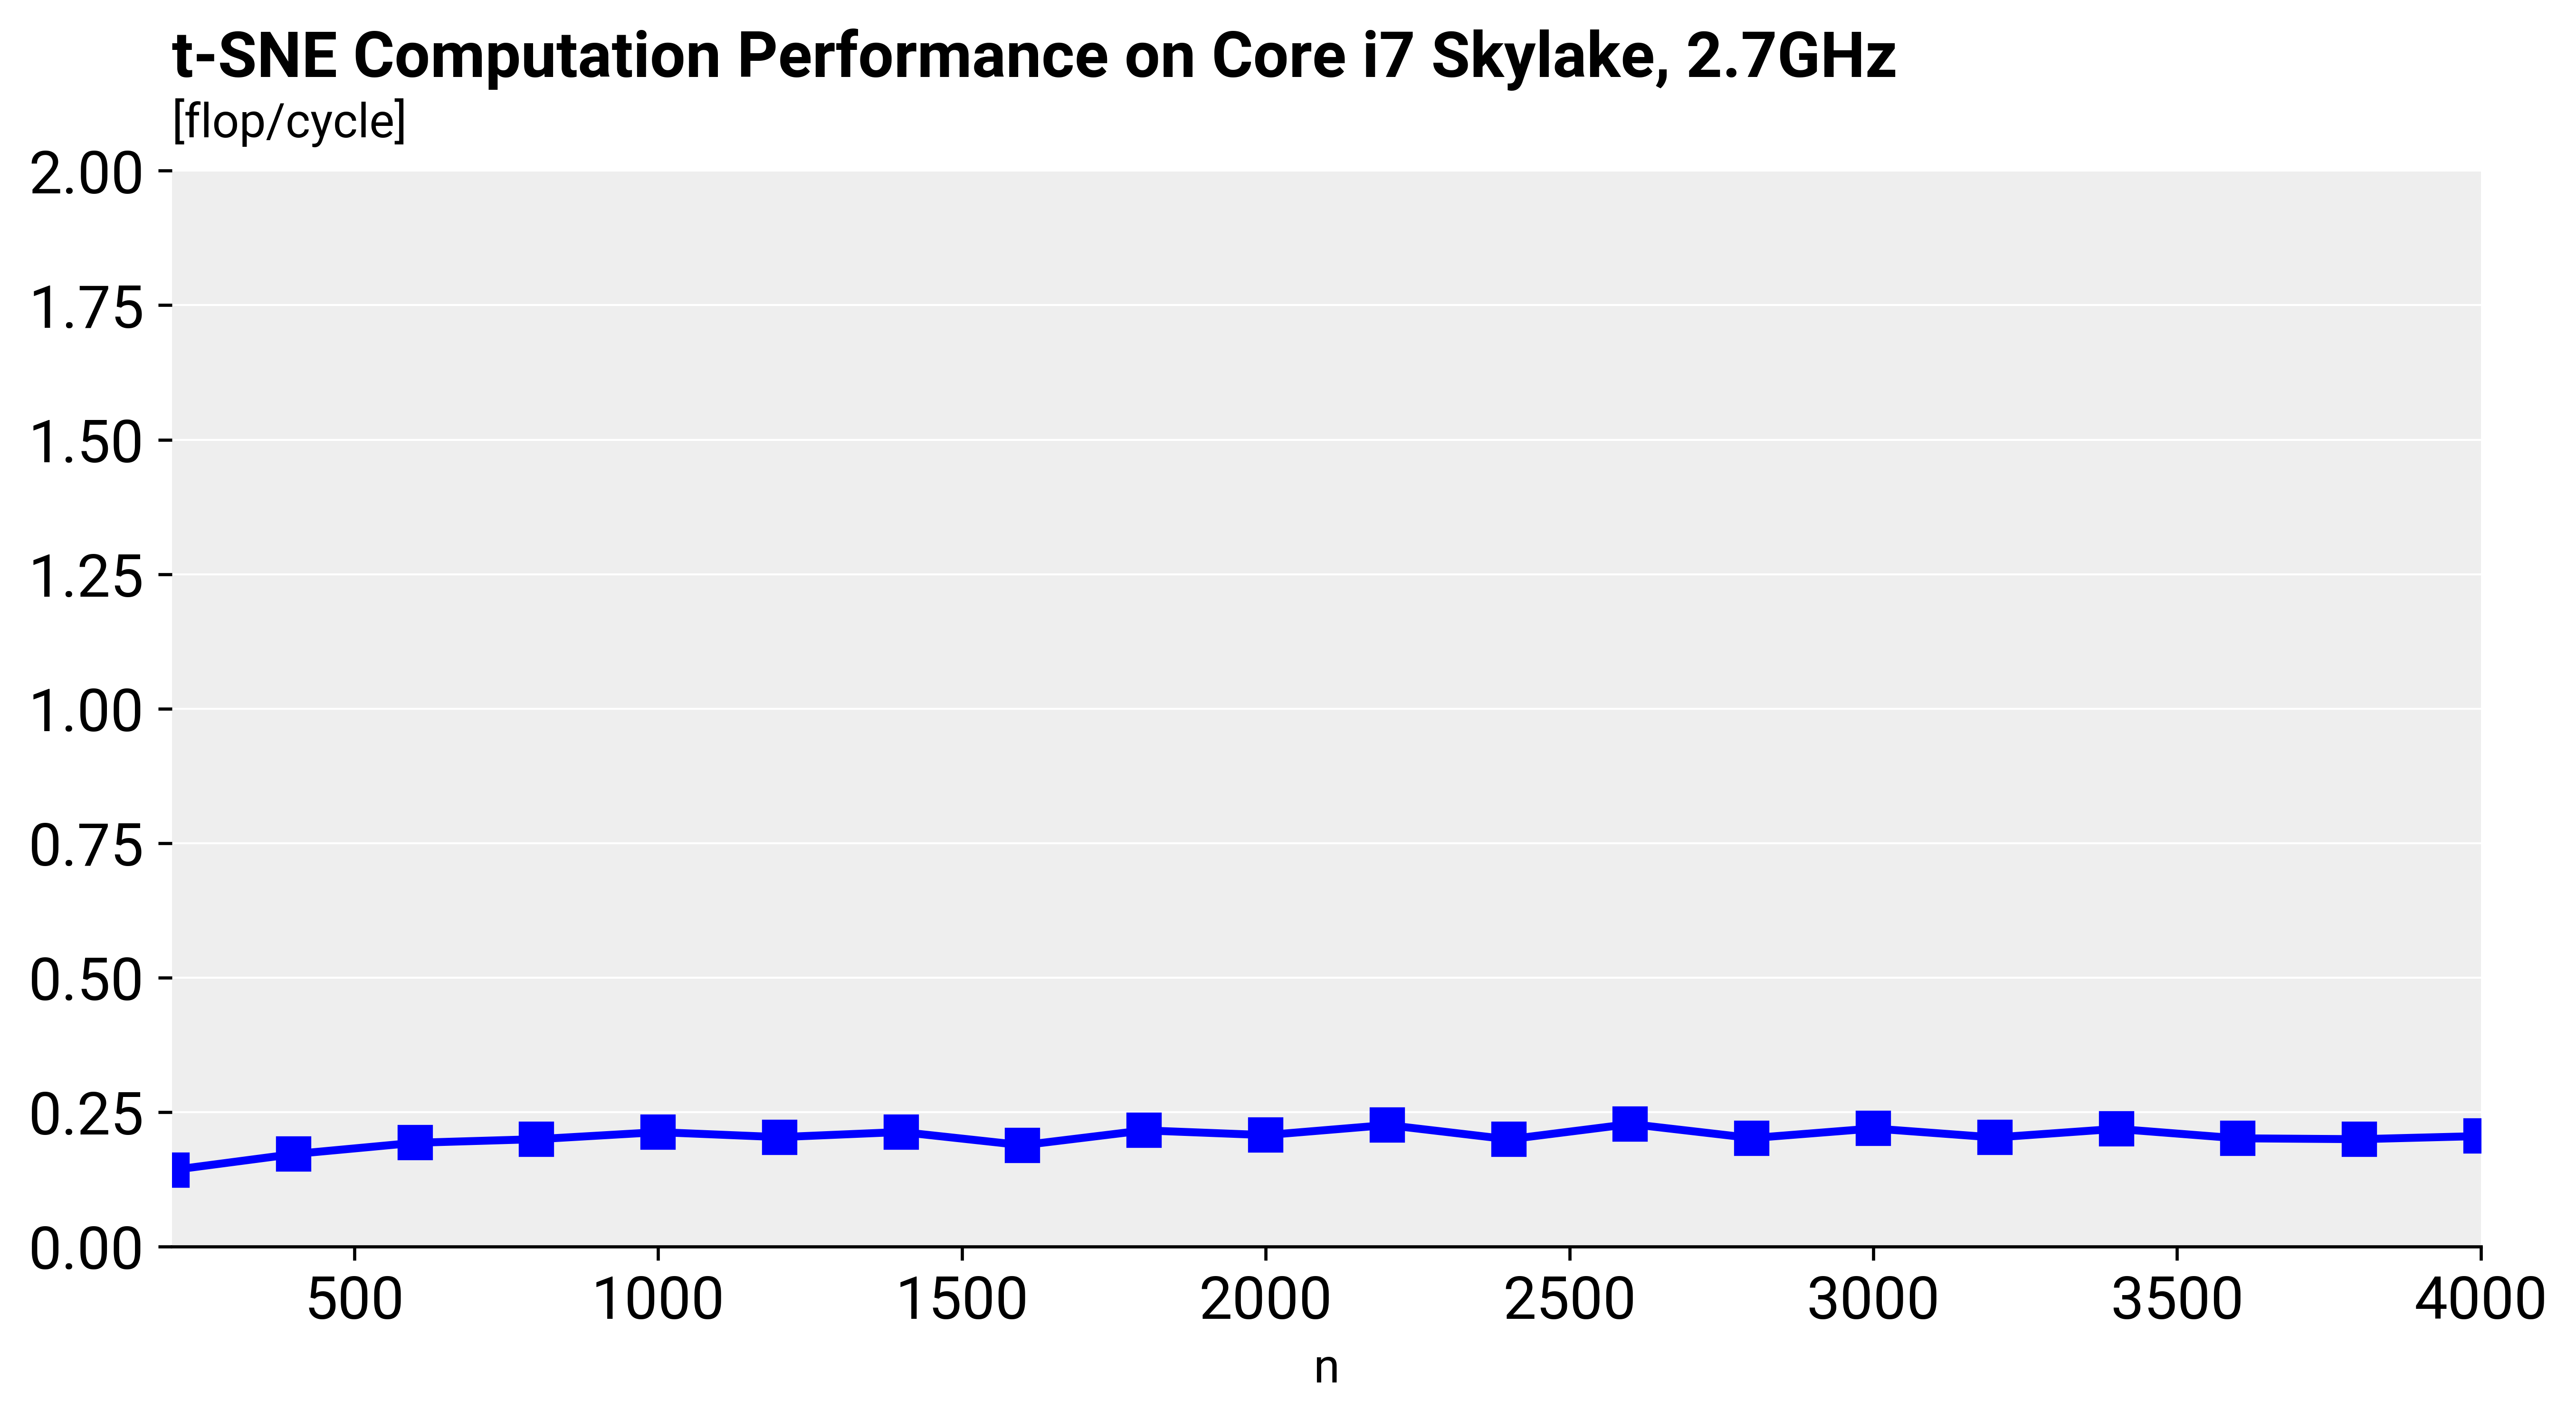

In [9]:
title = "t-SNE Computation Performance on Core i7 Skylake, 2.7GHz"
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ylabel = "flop/cycle"
color = ["gray", "blue", "red"]
ylim = 2
    
fig = plt.figure()
fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

ax.plot(N, performance_total, linewidth=lw, c=color[1], marker=marker, markersize=markersize)
ax.set_ylim([0, ylim])

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)

# For runtime plots where on the yaxis there is an exponent, place the text on the axis title
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

exponent_text = ''
ax.set_title('[{}]{}'.format(ylabel, exponent_text), fontsize=labels_fontsize, 
             position=(0,1.0), ha='left', va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()

Now observe the performance by function.

In [10]:
function_list=("normalize", "compute_pairwise_affinity_perplexity", "symmetrize_affinities", 
               "early_exageration", "compute_low_dimensional_affinities", "gradient_computation", 
               "gradient_update", "normalize_2")

performance_by_function = flops_by_function / cycles[:,:-1]

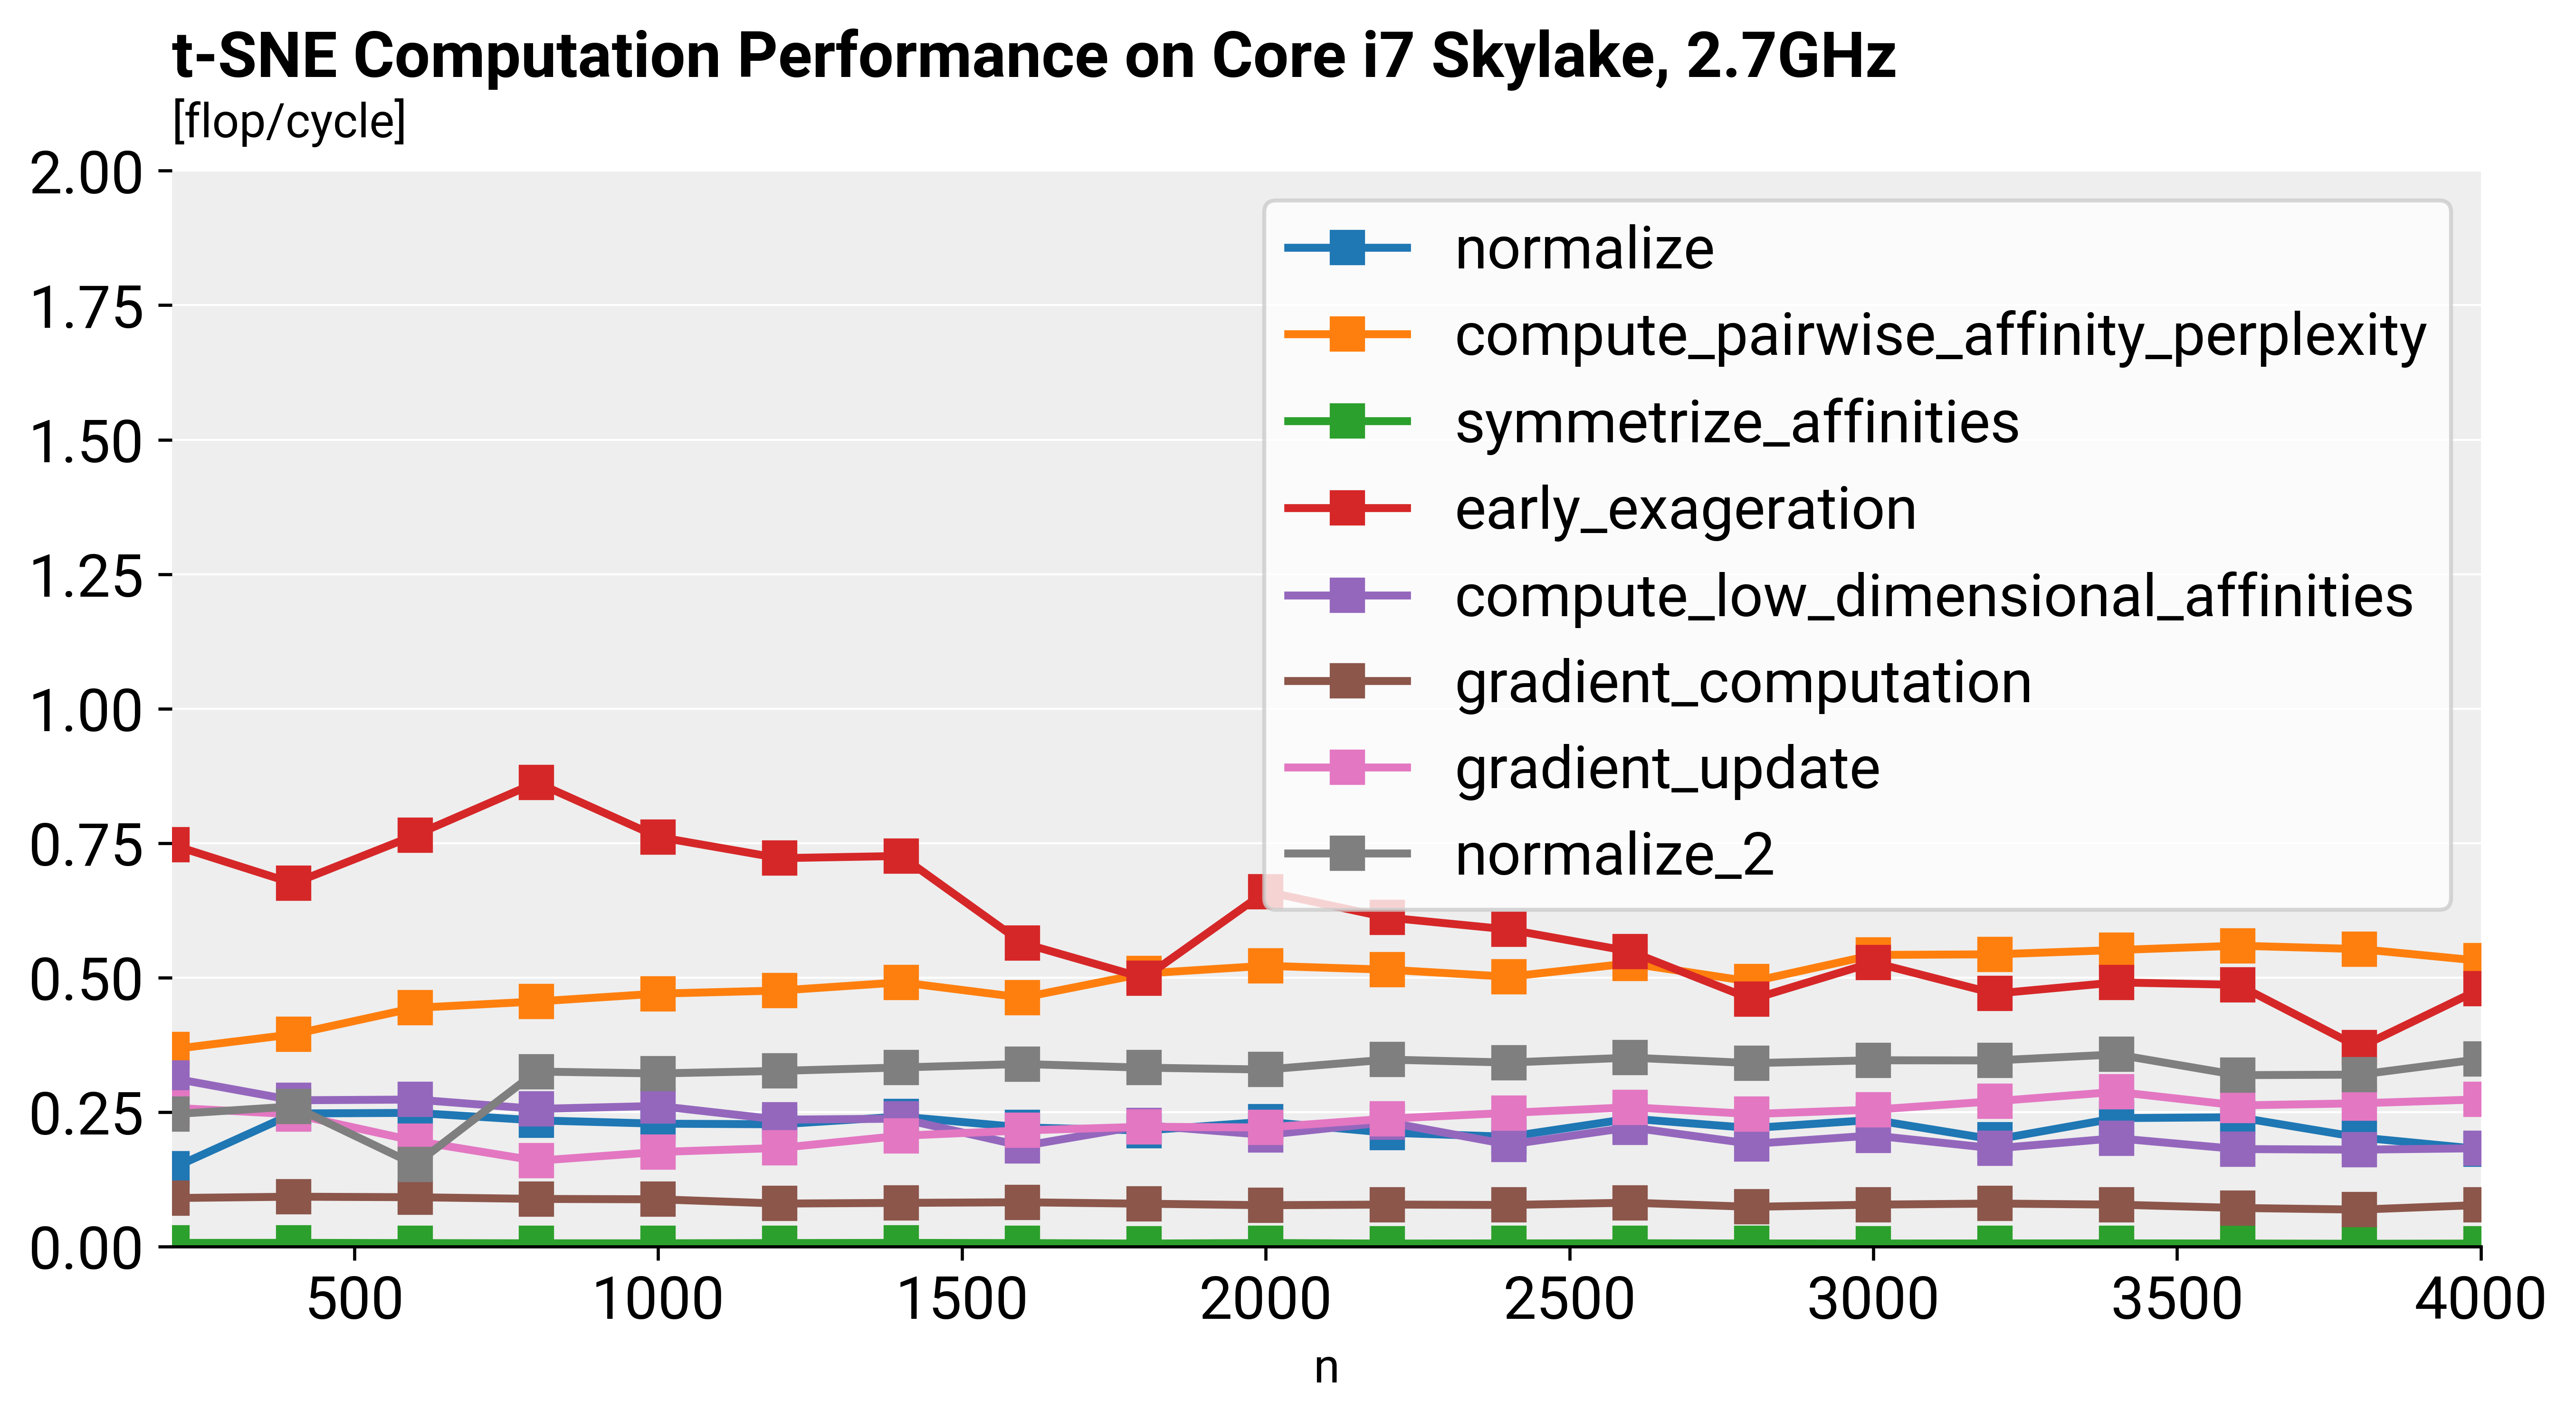

In [11]:
title = "t-SNE Computation Performance on Core i7 Skylake, 2.7GHz"
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ylabel = "flop/cycle"
color = ["gray", "blue", "red"]
ylim = 2
    
fig = plt.figure()
fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

for i, func in enumerate(function_list):
    ax.plot(N, performance_by_function[:,i], linewidth=lw, marker=marker, markersize=markersize, label=func)
#ax.plot(N, performance, linewidth=lw, c=color[1], marker=marker, markersize=markersize)
ax.set_ylim([0, ylim])
ax.legend(loc=1)

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)

# For runtime plots where on the yaxis there is an exponent, place the text on the axis title
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

exponent_text = ''
ax.set_title('[{}]{}'.format(ylabel, exponent_text), fontsize=labels_fontsize, 
             position=(0,1.0), ha='left', va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()